# Regression Models

Regression aims to estimate the world state $w$ for a given observations $\mathbf{x}$ by modeling $P(w|\mathbf{x})$ based on obtained data $\{\mathbf{x}_{i}, w_{i}\}_{i=1}^N$.

## Table of contents:
* [Maximum Likelihood Linear Regression](#ml-linear-regression)
* [Bayesian linear regression](#bayesian-linear-regression)
* [Non-linear regression - Maximum Likelihood](#non-linear-regression-ml)
* [Non-linear regression - Bayesian Inference](#non-linear-regression-bayes)
* [Kernels and Gaussian process regression](#kernel-gaussian-process-regression)
* [Sparse linear regression](#sparse-linear-regression)
* [Dual linear regression](#dual-linear-regression)
* [Relevance vector regression](#relevant-vector-regression)
* [Regression to multivariate data](#multivariate-data)

# Non-linear regression - Maximum Likelihood <a class="anchor" id="non-linear-regression-ml"></a>

In the previous sections, the bases we employed were $\mathbf{x}_{i} = (1, \tilde{\mathbf{x}}_{i}^{T})^{T}$, only up to the linear order. We may employ higher order terms or even some non linear functions of $\mathbf{x}$. Here, we consider the gaussian bases.

$$\begin{align}
\mathbf{z} \quad & = &\quad
\begin{pmatrix}
1 \\
exp(-\frac{(x - a_{1})^{2}}{2\lambda^{2}}) \\
exp(-\frac{(x - a_{2})^{2}}{2\lambda^{2}}) \\
exp(-\frac{(x - a_{3})^{2}}{2\lambda^{2}}) \\
exp(-\frac{(x - a_{4})^{2}}{2\lambda^{2}}) \\
exp(-\frac{(x - a_{5})^{2}}{2\lambda^{2}}) \\
\end{pmatrix} 
\end{align}$$

Essentially, we can substitute $\mathbf{z}$ to $\mathbf{x}$ in the previous arguements. We consider the maximum likelihood and Bayesian inference.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as spsp
import scipy.stats as spst
%matplotlib inline

# usual gangs

In [981]:
def generate_nice_params(ng, intvl):
    """
    Arguments:
        ng:    scalar. number of gaussians.
        intvl: distance between the means of gaussians.

    Output:
        lmd: std of the gaussians.
        wgt: weight distribution of the gaussians.
        sg:  noise rides on top of the generated curve.
    """
    # ng = scalar. number of gaussians
    lmd = intvl + (np.random.rand() - .5)
    wgt = 3 * np.random.rand(ng + 1) + .5
    sg = 0.2 * wgt.mean()
    wgt *= np.random.choice([-1, 1], ng + 1)
    wgt[0] = np.random.rand() - .5
    return lmd, wgt, sg

def generate_samples(ng, nx, ns, wgt, lmd, sg, x):
    """
    Arguments:
        ng:   scalar. number of gaussians.
        nx:   number of points between xlim (-10. and +10.) -> grid.
        ns:   number of samples
        wgt:  weight distribution of the gaussians.
        lmd:  std of the gaussians.
        sg:   noise rides on top of the generated curve.
        x:    x coodinates of the grid.
    
    Output:
        bases:     The basis gaussians on the grid. (ng+1 x nx) 1 for bias.
        bases_smp: The basis gaussians sampled from the grid. (ng x ns) 
        grdtr:     The generated curve. ground truth. (1, ng)
        cntrs:     The centers of the gaussians. (ng, )
        xs:        sampled x (ns, ) 
        smp:       sampled from grdtr (ns, )
        
    """
    cntrs = np.arange(-lmd * (ng - 1) / 2, lmd * (ng + 1) / 2, lmd)
    bases = np.zeros((ng + 1, nx))
    bases[0, :] = np.ones(nx)
    for i in range(1, ng + 1, 1):
        bases[i, :] = spst.norm.pdf(x, cntrs[i - 1], 0.4 * lmd)
    grdtr = np.dot(wgt[np.newaxis, :], bases)
    idx = np.random.choice(np.arange(nx), ns, replace=False)
    idx.sort()
    xs = x[idx]
    smp = grdtr[:, idx] + np.random.normal(0, sg, ns)
    bases_smp = bases[:, idx]
    return bases, bases_smp, grdtr, cntrs, xs, smp.T

def plot_samples(x, wgt, bases, grdtr, xs, smp):
    for i in range(1, bases.shape[0]):
        plt.plot(x, wgt[i] * bases[i], '-')
    plt.plot(x, grdtr.squeeze(), 'k-', lw = 3)
    plt.plot(xs, smp.squeeze(), 'k.', markersize = 10)
    plt.xlabel("x")
    plt.ylabel("w")

def plot_lg_pdf(phi, sg, cntrs, lmd):
    # z = D x N
    # w = N x 1
    # phi = D x 1
    # sg = scalar
    nx = 201
    ny = 201
    nn = nx * ny
    xres = np.linspace(-10, 10, nx)
    yres = np.linspace(-2, 2, ny)
    yg, xg = np.meshgrid(yres, xres)
    x_flat = xg.reshape(1, nn)
    y_flat = yg.reshape(1, nn)
    bases = np.zeros((ng + 1, nn))
    bases[0, :] = np.ones(nn)
    for i in range(1, ng + 1, 1):
        bases[i, :] = spst.norm.pdf(x_flat.squeeze(), cntrs[i - 1], 0.4 * lmd)
    mu_flat = np.dot(phi.T, bases).squeeze()
    lg_pdf = spst.norm.pdf(y_flat, mu_flat, sg).reshape((nx, ny))
    lg_pdf = np.flipud(lg_pdf.T)
    plt.imshow(lg_pdf, extent=[-10, 10, -2, 2])

def maximum_likelihood_inference(z, w):
    # z = D x N
    # w = N x 1
    # phi = D x 1
    # sg = scalar
    zzt = np.dot(z, z.T)
    zztinv = np.linalg.inv(zzt)
    zw = np.dot(z, w)
    phi = np.dot(zztinv, zw)
    delta = w - np.dot(z.T, phi)
    sg2 = (delta ** 2).mean()
    sg = np.sqrt(sg2)
    return phi, sg

def evaluate_average_log_likelihood(x, w, phi, sg):
    likelhd = spst.norm(np.dot(phi.T, x), sg).pdf(w)
    log_likelhd = np.log(likelhd)
    ave_log_likehd = log_likelhd.mean()
    return ave_log_likehd

In [984]:
ns = 30
ng = 5
nx = 101

x_range = np.array([-10., 10.])
x = np.linspace(-10, 10, nx)
span = x_range[1] - x_range[0]
intvl = span / (ng + 1)

lmd, wgt, sg = generate_nice_params(ng, intvl)
bases, bases_smp, grdtr, cntrs, xs, smp = generate_samples(ng, nx, ns, wgt, lmd, sg, x)
phi, sge = maximum_likelihood_inference(bases_smp, smp)

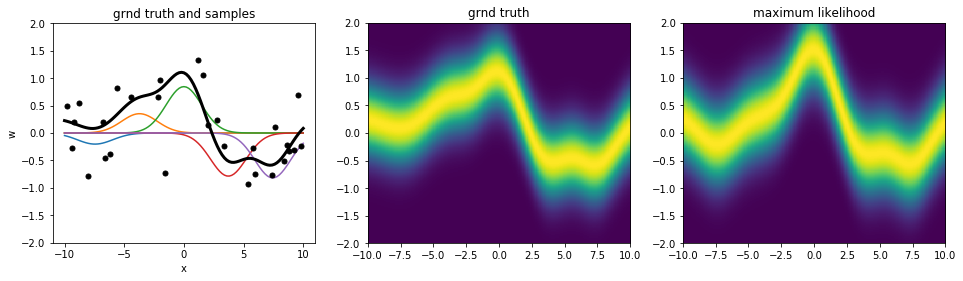

In [985]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)

ax1 = plt.subplot(1,3,1)
plot_samples(x, wgt, bases, grdtr, xs, smp)
plt.ylim([-2., 2.])
plt.title('grnd truth and samples')

ax2 = plt.subplot(1,3,2)
plot_lg_pdf(wgt, sg, cntrs, lmd)
plt.title('grnd truth')

ax3 = plt.subplot(1,3,3)
plot_lg_pdf(phi, sge, cntrs, lmd)
plt.title('maximum likelihood')

ax1.set_aspect(4.6)
ax2.set_aspect(4.2)
ax3.set_aspect(4.2)